# Read Me Before starting
In this notebook, we will perform in silico perturbation for many genes. The systematic perturbation simulation will require more knowledge about the operation of celloracle software. Here are several notes we recommend considering before starting the systematic simulation.

- It is a bad idea to start with this notebook if you are unfamiliar with CellOracle analysis. Please try our tutorial first.
- Please perform in silico perturbation simulation focusing on just one gene. We need to decide on several hyperparameters. Analyzing just a single gene to find the appropriate hyperparameters is highly recommended.
- In the codes below, we will perform in silico TF perturbation for each gene and save the result in the original data format. This may take a very long time. The hyperparameter tuning needs to be done before this step. Otherwise, you will waste your time.
- We need to use `Oracle` object, `Links` object, and `Gradient` object. Please see our tutorial for more information on how to prepare them.
- In this notebook, we will use Paul et al. 2015 hematopoiesis dataset. Some of the parts, especially step 4.1, need to be adjusted to your scRNA-seq data and the purpose of your analysis.
- The systematic simulation results made with this notebook will be analyzed in the following notebook.

# 0. Import libraries
## 0.1. Import public libraries

In [1]:
import copy
import glob
import importlib
import time
import os
import shutil
import sys
from importlib import reload

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm.notebook import tqdm

## 0.2. Import our library

In [2]:
import celloracle as co
from celloracle.applications import Oracle_development_module
co.__version__

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

'0.14.0'

## 0.3. Plotting parameter setting

In [3]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [5,5]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300

%matplotlib inline

# 1. Load data
## 1.1. Load oracle object

In [4]:
oracle = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/10_TDR119_pseudotime.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 13022
    n_genes: 3000
    cluster_name: global_annotation
    dimensional_reduction_name: X_umap.joint
    n_target_genes_in_TFdict: 12674 genes
    n_regulatory_in_TFdict: 872 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 318 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1637 genes
    k_for_knn_imputation: 325
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

## 1.2. Load inferred GRNs

In the previous notebook, we calculated GRNs. Now, we will use these GRNs for simulation.
We import GRNs which were saved in the Links object.



In [7]:
links = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/08_TDR119_celltype_GRNs.celloracle.links")
links

## 1.3. Load gradient object

This is the pseudotime object computed in another notebook

In [5]:
gradient = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/11_TDR119_pseudotime_knn_325.celloracle.gradient")

# Please make sure that the number of cells and dimensional reduction data is exact same between oracle object and gradient object
print(oracle.adata.shape, gradient.embedding.shape)

assert((oracle.adata.obsm[oracle.embedding_name] == gradient.embedding).all())

(13022, 3000) (13022, 2)


# 2. Process GRNs to make predictive models for simulation

## 2.1. Fit lineat model again


In [8]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

  0%|          | 0/14 [00:00<?, ?it/s]

# 3. Check TF list that can be used for simulation.

Celloracle's simulation uses GRNs for the signal propagation. It means it is not possible if TF have no connection in the inferred GRN. Before starting systematic simulation, let's check which TF exist in the GRN. 


If your gene of interest is not in the list below, you cannot use that gene for celloracle perturbation-simulation.
There are several possibilities why the gene is not in the list. 
For example, celloracle's GRN inference method may fail to detect a gene regulatory connection in the following cases.

- The gene is not in the gene expression marix after gene filtering. 
- Valiability level is too low.
- Gene expression level is too low or gene expression contains too many dropout.
- The gene does not have DNA-binding motifs
 


In [9]:
# You can get the list of genes that have at least one regulatory connection in the inferred GRNs.
genes = oracle.active_regulatory_genes
len(genes)

308

In [10]:
len(genes)

308

# 4. Systematic simulation

We will do simulations for the all TFs listed above. 
The results will be saved in the local folder as a hdf5 format so that we can access to the results quickly after finishing all calculations.

Here, we will do simulation per TF KO for five conditions. 

1. Simulate TF KO using whole cells.
2. Simulate TF KO focusing on Lineage_GM.
3. Simulate TF KO focusing on Lineage_ME.
4. Simulate TF KO focusing on Granurocyte cluster.
5. Simulate TF KO focusing on Monocyte cluster.


## 4.1 Make cell index list

For the simulation conditions #2~5, we will do simulation with a subset of cells. 
We need to get cell index list first. 

In [11]:
oracle.adata

AnnData object with n_obs × n_vars = 13022 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight', 'peaks_celltype.weight', 'Lineage_Meso', 'Lineage_NeuroEcto', 'Pseudotime_Lineage_Meso', 'Pseudotime_Lineage_NeuroEcto', 'Pseudotime'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators', 'isin_actve_regulators'
    uns: 'hvg', 'log1p', 'global_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna'
    layers: 'raw_count', 'normalized_count', 'imputed_count', 'simulation_input'

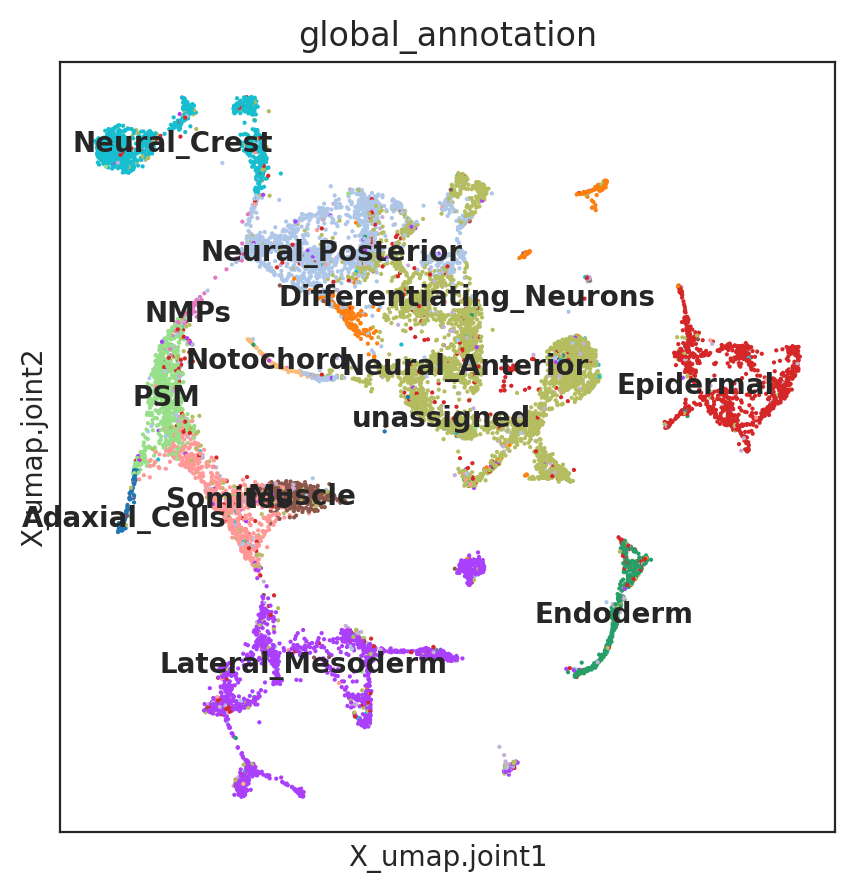

In [12]:
# Check data first
sc.pl.embedding(oracle.adata, basis="X_umap.joint", 
                color="global_annotation", legend_loc="on data")

In [14]:
# List of cluster name
sorted(list(oracle.adata.obs["global_annotation"].unique()))

['Adaxial_Cells',
 'Differentiating_Neurons',
 'Endoderm',
 'Epidermal',
 'Lateral_Mesoderm',
 'Muscle',
 'NMPs',
 'Neural_Anterior',
 'Neural_Crest',
 'Neural_Posterior',
 'Notochord',
 'PSM',
 'Somites',
 'unassigned']

In [15]:
# Get cell_id

cell_idx_Lineage_mesoderm = np.where(oracle.adata.obs["global_annotation"].isin([
    'NMPs', 'PSM', 'Somites', 'Muscle']))[0]

cell_idx_Lineage_neuro_ectoderm = np.where(oracle.adata.obs["global_annotation"].isin([
    'NMPs', 'Neural_Posterior', 'Neural_Anterior']))[0]

# cell-type specific (one cell-type only, to see the master regulatory TF within that cell-type)
cell_idx_somites = np.where(oracle.adata.obs["global_annotation"].isin([
    'Somites']))[0]

cell_idx_neural_posterior = np.where(oracle.adata.obs["global_annotation"].isin([
    'Neural_Posterior']))[0]


In [16]:
# Make dictionary to store the cell index list

index_dictionary = {"Whole_cells": None,
                    "Lineage_meso": cell_idx_Lineage_mesoderm,
                    "Lineage_neuroecto": cell_idx_Lineage_neuro_ectoderm,
                    "Somites": cell_idx_somites,
                    "Neural_Posterior": cell_idx_neural_posterior}

## 4.2. Make a custom function for the systematic KO workflow


We will do many simulations, and all results will be saved in a single hdf5 file. Using `Oracle_development_module`. This is custom class to save and load simulation results.
With this class, data will be stored hierarchically in one hdf5 file.

When save the results, please enter two parameters: gene and misc.
These two parameters are used as a key to save/load files into/from hdf5. 

> 1. gene (str): name of gene used in the perturb-simulation.
> 2. misc (str): name of the simulation, name of cell population or KO condition or etc. 

For example, you can save and load analysis results as follows.

 Save data into hdf file

```python
dev.set_hdf_path(path=file_path) 
dev.dump_hdf5(gene="Gata1", misc="Lineage_GMP")
```
 
 Load data from hdf file
```python
dev = Oracle_development_module()
dev.set_hdf_path(path=file_path) 
dev.load_hdf5(gene="Gata1", misc="Lineage_GMP")
 ```

In [17]:
# 0. Define parameters
n_propagation = 3
n_neighbors=200

# define the filename/path for the systematic in silico KO result
file_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/12_TDR119_NMP_in_silico_KO_knn_325.celloracle.hdf5" # Please use .hdf5 for extension.


def pipeline(gene_for_KO):
     
    # 1. Simulate KO
    oracle.simulate_shift(perturb_condition={gene_for_KO: 0},
                                 ignore_warning=True,
                                 n_propagation=3)
    oracle.estimate_transition_prob(n_neighbors=n_neighbors, knn_random=True, sampled_fraction=1)
    oracle.calculate_embedding_shift(sigma_corr=0.05)

    # Do simulation for all conditions.
    for lineage_name, cell_idx in index_dictionary.items():
        
        dev = Oracle_development_module()
        # Load development flow
        dev.load_differentiation_reference_data(gradient_object=gradient)
        # Load simulation result
        dev.load_perturb_simulation_data(oracle_object=oracle, cell_idx_use=cell_idx, name=lineage_name)
        # Calculate inner product
        dev.calculate_inner_product()
        dev.calculate_digitized_ip(n_bins=10)
        
        # Save results in a hdf5 file.
        dev.set_hdf_path(path=file_path) 
        dev.dump_hdf5(gene=gene_for_KO, misc=lineage_name)
        

    
    

In [16]:
#os.remove(file_path)

## 4.3. Test

Try function for one gene to check the function above is working.

In [37]:
pip install tables

  Using cached tables-3.8.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.7/383.7 kB 7.4 MB/s eta 0:00:0000:01
  Using cached blosc2-2.0.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.9 MB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached msgpack-1.0.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (322 kB)
Note: you may need to restart the kernel to use updated packages.


In [18]:
%%time
# Test pipeline with one gene
pipeline(gene_for_KO="meox1")

No hdf file found in the path. New hdf5 file was created.
CPU times: user 4min 14s, sys: 17.9 s, total: 4min 32s
Wall time: 1min 44s


## 4.4. Check result of test

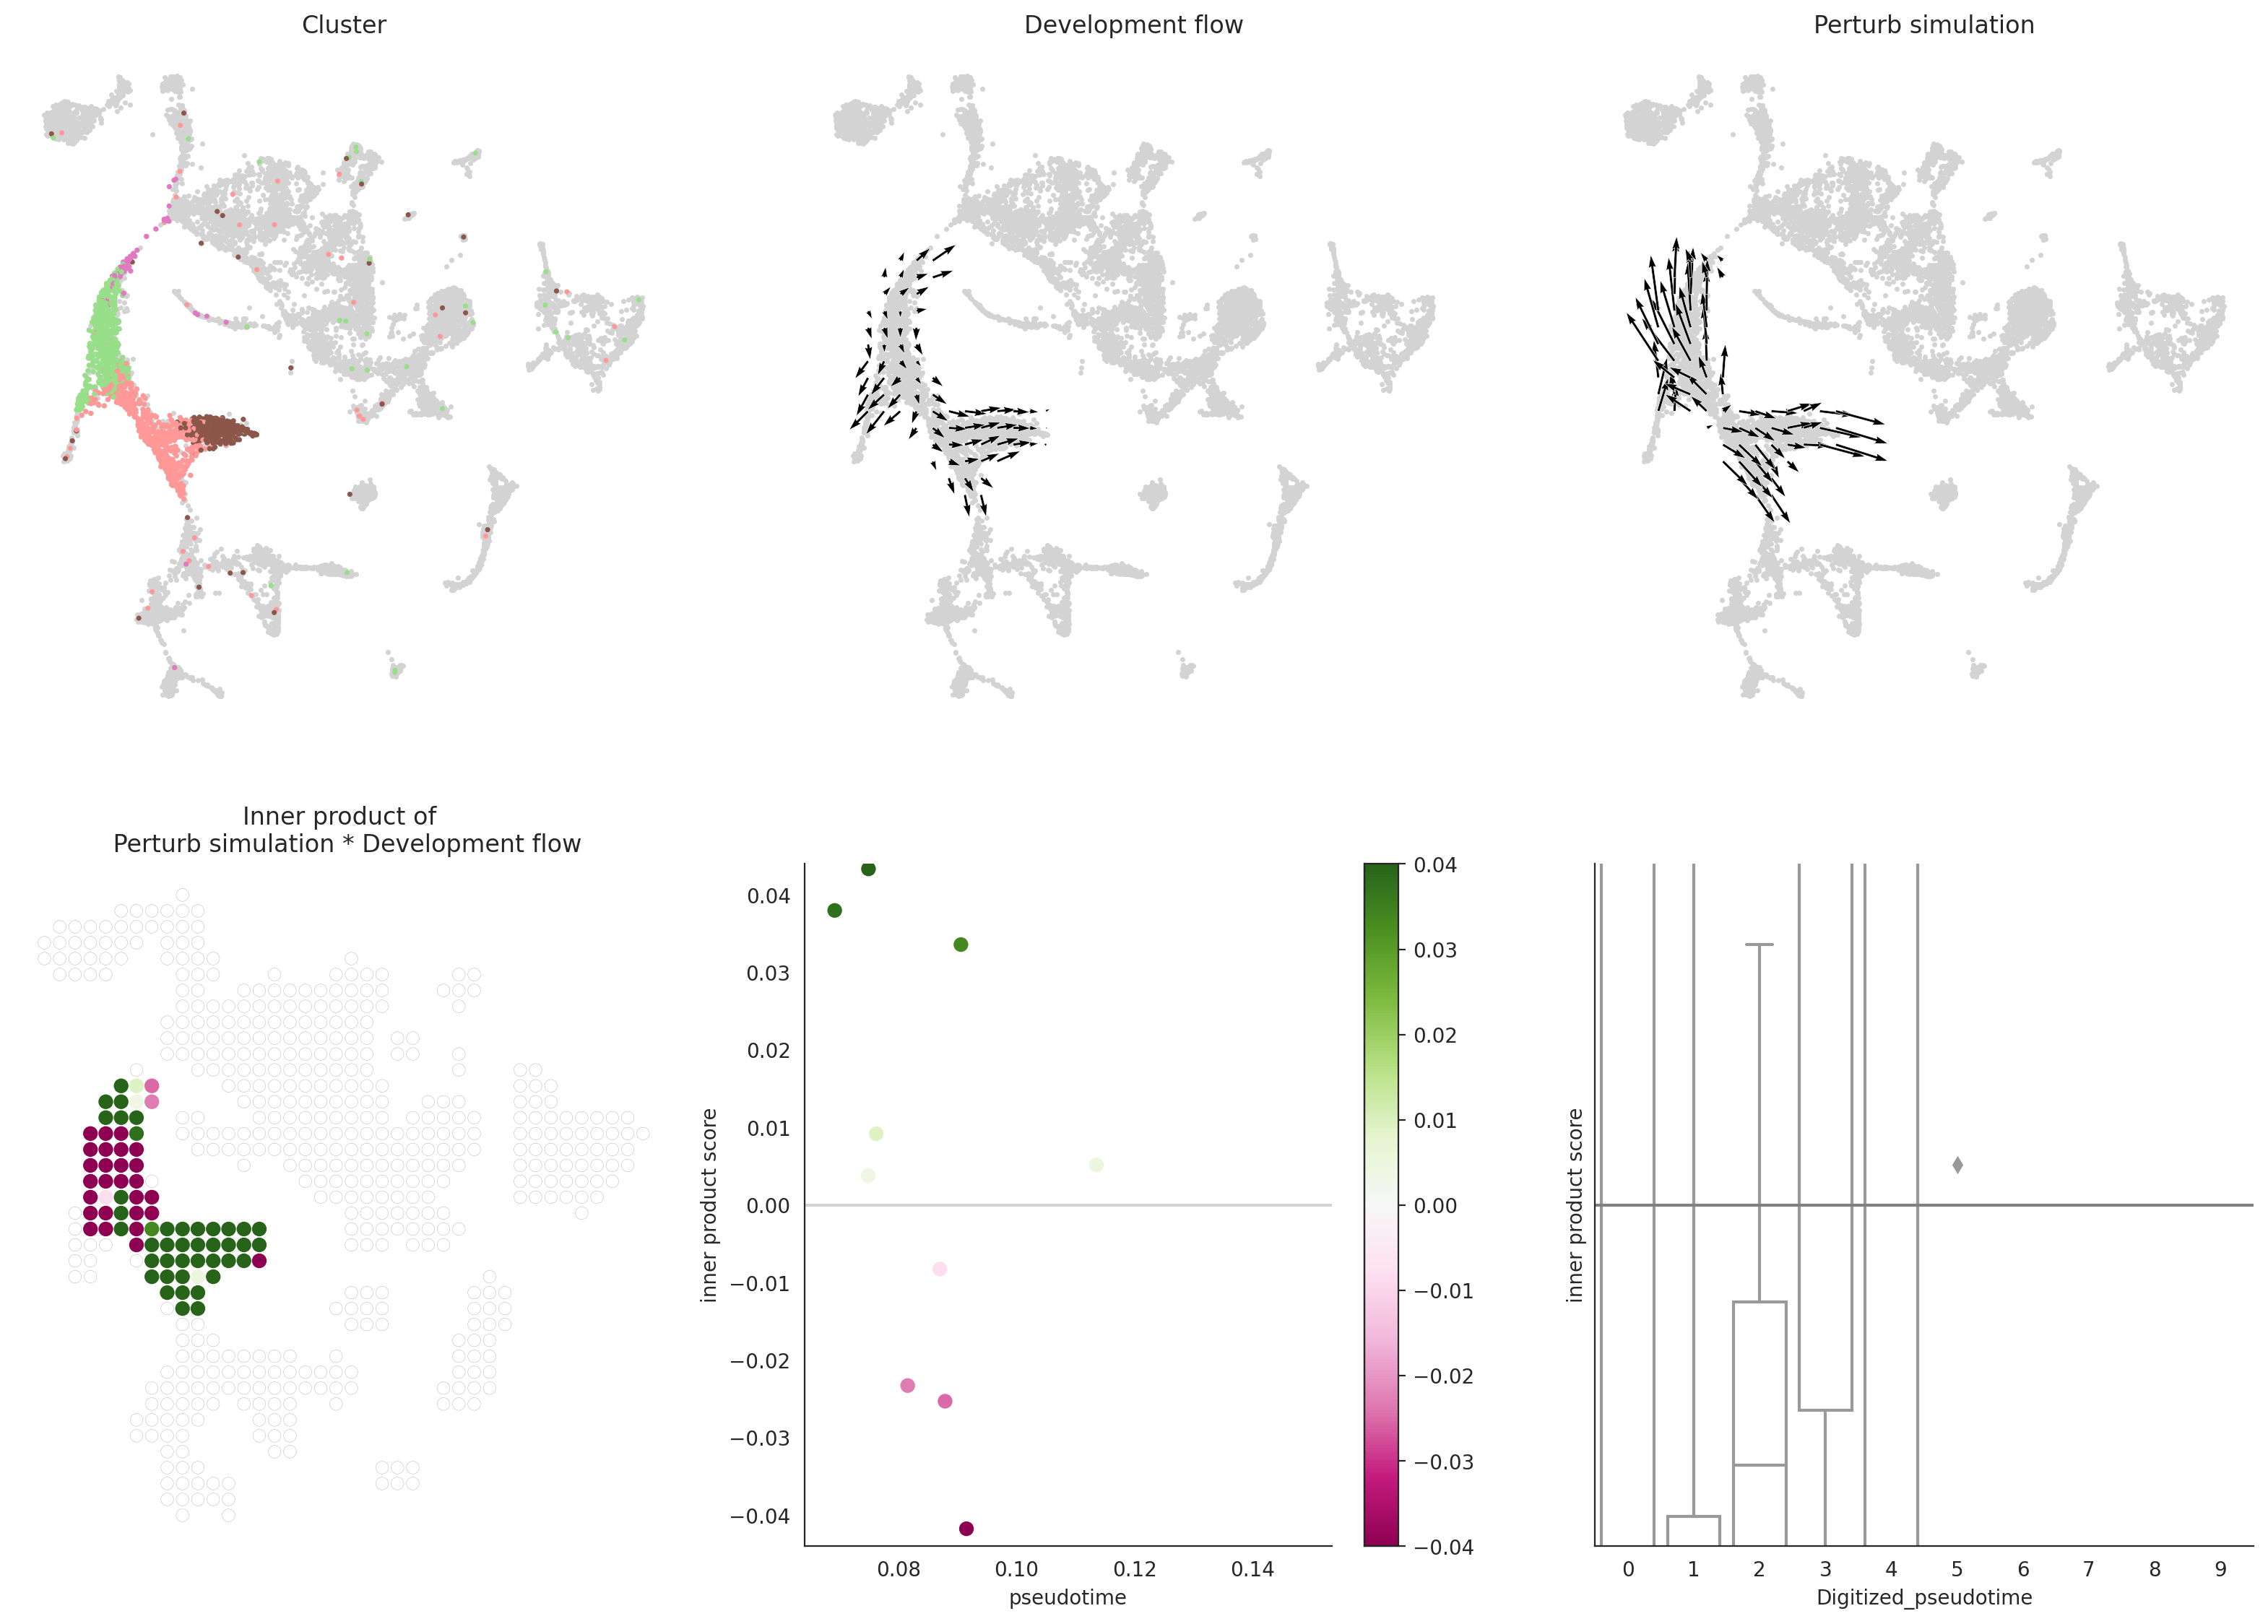

In [20]:
# Make a new Oracle_developmennt_module object to read calculation result
dev_test = Oracle_development_module()

# Read result
dev_test.set_hdf_path(path=file_path)
dev_test.load_hdf5(gene="meox1", misc="Lineage_meso")

# Visualize result
dev_test.visualize_development_module_layout_0(s=5, scale_for_simulation=5, s_grid=40,
                                          scale_for_pseudotime=40, vm=0.04)

## NOTES (11/6/2023 - YJK)

- This mesodermal lineage doesn't look great in terms of the flow of the developmental arrows (cell-cell transition probabilities).
- We rely on CellOracle's internal functions (DPT + Velocyto) to compute the pseudotime-driven cell-cell transition probabilities. We don't know how good it is, and also how easy/hard it would be to implement Palantir/CellRank for this purpose.

- Question: Where is this "developmetnal flow" computed? Is it computed right after we compute the Pseudotime? 

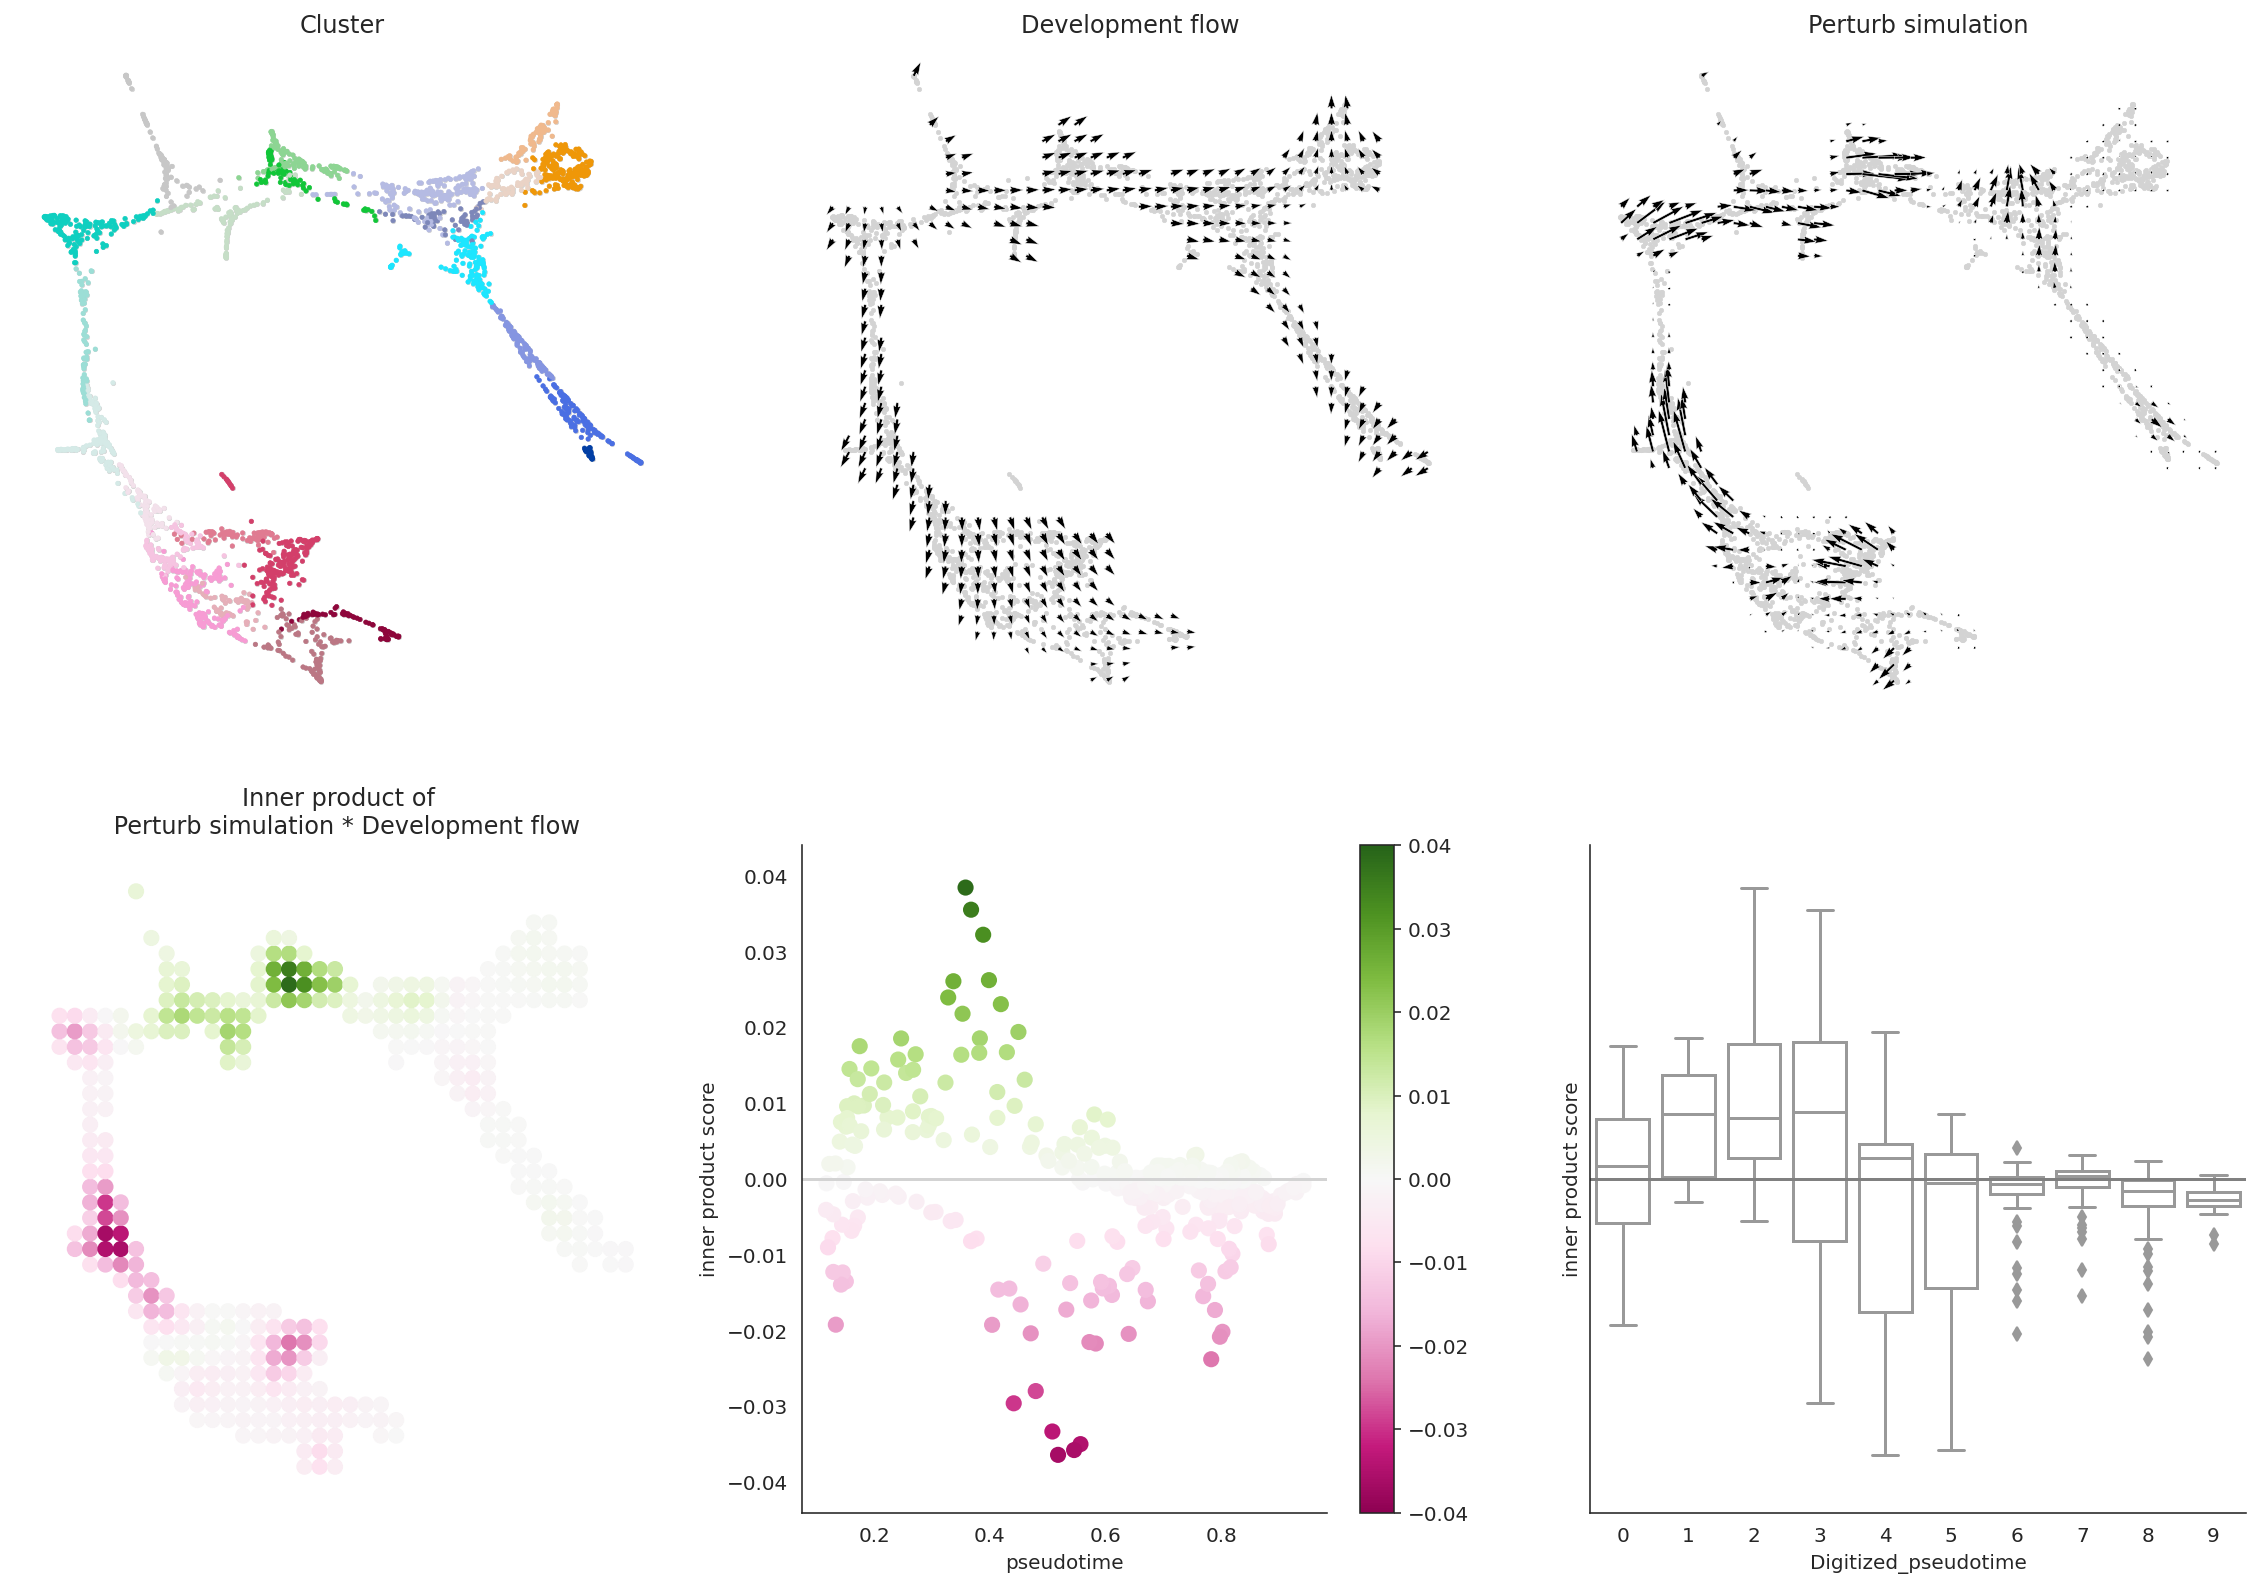

In [19]:
# Make a new Oracle_developmennt_module object to read calculation result
dev_test = Oracle_development_module()

# Read result
dev_test.set_hdf_path(path=file_path)
dev_test.load_hdf5(gene="meox1", misc="Lineage_meso")

# Visualize result
dev_test.visualize_development_module_layout_0(s=5, scale_for_simulation=0.5, s_grid=50,
                                          scale_for_pseudotime=50, vm=0.04)

## 4.5. Run pipeline for all genes.



It might take long time - 8-12 hours depending on the number of TFs, and number of cells in your dataset.

In [ ]:
%%time
for gene in tqdm(genes):
    pipeline(gene_for_KO=gene)

  0%|          | 0/308 [00:00<?, ?it/s]

# save the oracle object (now after the simulation)


In [ ]:
oracle.to_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/13_TDR119_pseudotime_knn_325_KOsimulated.celloracle.oracle")